# Machine Learning - Diabetes
Code by Fernando Cruvinel Casas

In [1]:
import numpy as np
import pandas as pd

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import pointbiserialr

import ipywidgets as widgets
from IPython.display import display, clear_output

Tirar os 0 de onde não deveria ter, ou seja nas colunas de váriaveis onde não faz sentido  ter esses valores e substituir por NaN:
(Glucose, BloodPressure, SkinThickness, BMI, DiabetesPedigreeFunction, Age)

In [2]:
df = pd.read_csv("/diabetes.csv")
df.head()
cols_com_zero = ['Glucose', 'BloodPressure', 'BMI', 'SkinThickness', 'DiabetesPedigreeFunction', 'Age']
df[cols_com_zero] = df[cols_com_zero].replace(0, np.nan)
df.isnull().sum() #utilizado para verificar a quantidade de valores ausentes por variavél.
#df.info()
#df.describe()

,0
Pregnancies,0
Glucose,9
BloodPressure,54
SkinThickness,232
Insulin,3
BMI,21
DiabetesPedigreeFunction,1
Age,0
Outcome,0


In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,0.0,33.6,627.0,50,1
1,1,85.0,66.0,29.0,0.0,26.6,351.0,31,0
2,8,183.0,64.0,NaN,0.0,23.3,672.0,32,1
3,1,89.0,66.0,23.0,94.0,28.1,167.0,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2288.0,33,1


Mapa de valores ausentes para facilitar a visalização dos dados não coletados, onde fica evidente que o Skin Thickness foi o dado menos colocado, é vai ser necessário levar isso em conta na análise.

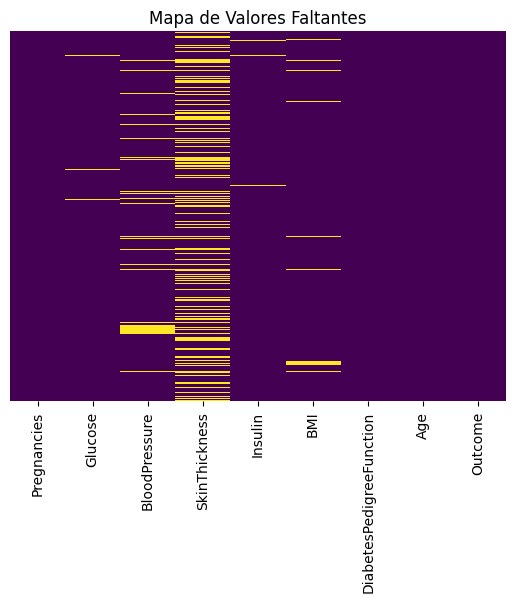

In [4]:
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Mapa de Valores Faltantes')
plt.show()

Substui os dados faltantes por sua média ou médiana, dependendo do que fazia mais sentido para cada tipo de dado. Outra alternativa teria sido fazer um df.dropna() para Glucose o Insulin, que tem 3 e 9 dados faltantes respectivamente, e o que isso teria feito seria excluir essas linhas de dados do estudo, porém optei por manter as linhas e substituir os ausentes.

In [5]:
# df['Glucose'].fillna(df['Glucose'].mean(), inplace=True)
# df['BloodPressure'].fillna(df['BloodPressure'].mean(), inplace=True)
# df['SkinThickness'].fillna(df['SkinThickness'].median(), inplace=True)
# df['BMI'].fillna(df['BMI'].median(), inplace=True)
# df['Insulin'].fillna(df['Insulin'].median(), inplace=True)

O KNN (K-Nearest Neighbors) é um algoritmo de classificação baseado em instâncias, que toma decisões considerando os k vizinhos mais próximos de um ponto novo, com base em alguma medida de distância. Ou seja, ele classifica um novo paciente observando os diagnósticos dos pacientes mais parecidos com ele no conjunto de treino. Escolhi o KNN no início do projeto, especialmente para a imputação de valores ausentes, porque ele considera a estrutura do próprio dataset para preencher lacunas. Isso significa que, ao substituir valores faltantes, o KNN busca os registros mais semelhantes (com base nas demais variáveis) e estima os valores com base nesses vizinhos. Achei esse método mais interessante do que simplesmente usar médias ou medianas, pois preserva melhor as características individuais dos pacientes, mantendo coerência entre as variáveis e contribuindo para a qualidade dos modelos posteriores.



BloodPressure    0
BMI              0
SkinThickness    0
dtype: int64


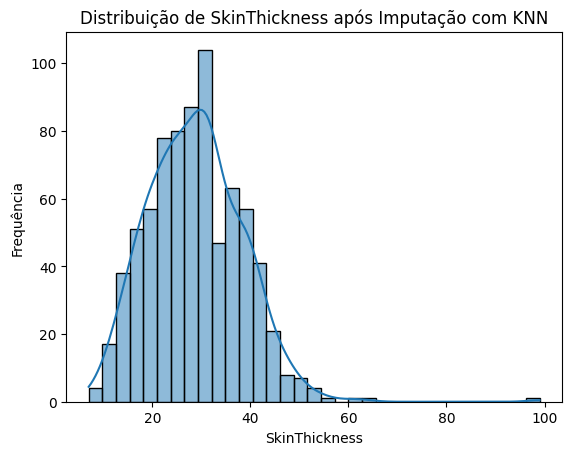

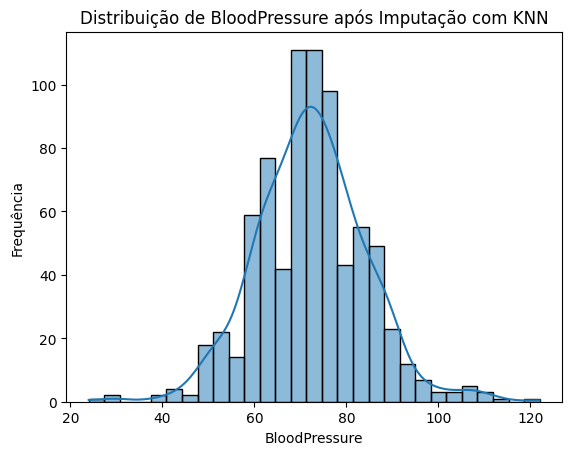

In [6]:

#Selecionar as colunas relevantes para a imputação
features = ['BloodPressure', 'BMI', 'SkinThickness']
df_subset = df[features]

#Padronizar os dados para evitar que variáveis com escalas diferentes distorçam a distância
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_subset)
# Criar o KNNImputer e imputar os valores ausentes na coluna 'SkinThickness'
imputer = KNNImputer(n_neighbors=5)
imputed_scaled_data = imputer.fit_transform(scaled_data)

# Reverter a padronização (se necessário) para analisar os valores no contexto original
imputed_data = scaler.inverse_transform(imputed_scaled_data)
df_imputed = pd.DataFrame(imputed_data, columns=features)

# Verificar se existem mais valores ausentes
print(df_imputed.isnull().sum())

#Visualização SkinThickness após a imputação
sns.histplot(df_imputed['SkinThickness'], kde=True)
plt.title('Distribuição de SkinThickness após Imputação com KNN')
plt.xlabel('SkinThickness')
plt.ylabel('Frequência')
plt.show()
#Vizualização BloodPressure após a impotação
sns.histplot(df_imputed['BloodPressure'], kde=True)
plt.title('Distribuição de BloodPressure após Imputação com KNN')
plt.xlabel('BloodPressure')
plt.ylabel('Frequência')
plt.show()

In [7]:
df.dropna()
df.isnull().sum()
#display(df)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,0.0,33.6,627.0,50,1
1,1,85.0,66.0,29.0,0.0,26.6,351.0,31,0
2,8,183.0,64.0,NaN,0.0,23.3,672.0,32,1
3,1,89.0,66.0,23.0,94.0,28.1,167.0,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2288.0,33,1


In [8]:
def analisar_coluna_outliers(df):
    def plotar(coluna):
        clear_output(wait=True)

        # Cálculo estatístico
        Q1 = df[coluna].quantile(0.25)
        Q3 = df[coluna].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        median = df[coluna].median()

        outliers = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]
        normais = df[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior)]

        # Subplots
        fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [2, 1]})

        sns.histplot(normais[coluna], bins=20, kde=False, color='skyblue', label='Valores normais', ax=axes[0], alpha=0.8)
        sns.histplot(outliers[coluna], bins=20, kde=False, color='crimson', label='Outliers', ax=axes[0], alpha=0.8)

        # Linhas no histograma
        axes[0].axvline(Q1, color='orange', linestyle='--', label=f'Q1 = {Q1:.1f}')
        axes[0].axvline(Q3, color='orange', linestyle='--', label=f'Q3 = {Q3:.1f}')
        axes[0].axvline(median, color='red', linestyle='--', label=f'Mediana = {median:.1f}')
        axes[0].axvline(limite_inferior, color='green', linestyle=':', label=f'Limite Inferior = {limite_inferior:.1f}')
        axes[0].axvline(limite_superior, color='purple', linestyle=':', label=f'Limite Superior = {limite_superior:.1f}')
        axes[0].set_title(f'Histograma de {coluna}')
        axes[0].set_xlabel(coluna)
        axes[0].set_ylabel('Frequência')
        axes[0].legend()

        # Boxplot
        sns.boxplot(x=df[coluna], color='skyblue', ax=axes[1])
        axes[1].axvline(median, color='red', linestyle='--', label='Mediana')
        axes[1].axvline(Q1, color='orange', linestyle='--', label=f'Q1 = {Q1:.1f}')
        axes[1].axvline(Q3, color='orange', linestyle='--', label=f'Q3 = {Q3:.1f}')
        axes[1].axvline(limite_inferior, color='green', linestyle=':', label=f'Limite Inferior = {limite_inferior:.1f}')
        axes[1].axvline(limite_superior, color='purple', linestyle=':', label=f'Limite Superior = {limite_superior:.1f}')
        axes[1].legend()
        axes[1].set_title(f'Boxplot de {coluna}')
        axes[1].set_xlabel(coluna)

        plt.tight_layout()
        plt.show()

        # Mostrar outliers
        print(f"\n🔎 Existem {len(outliers)} outliers na coluna '{coluna}'.")
        if len(outliers) > 0:
            print("\nOutliers encontrados:")
            for i, val in outliers[coluna].sort_values().items():
              if i < 100 and i > 9: #Somente para ficar alinhado o traço
                print(f"Índice: {i}   |  Valor: {val}")
              else:
                print(f"Índice: {i}  |  Valor: {val}")
    # Dropdown interativo com as colunas numéricas
    colunas_numericas = df.select_dtypes(include='number').columns.tolist()
    dropdown = widgets.Dropdown(options=colunas_numericas, description='Coluna:')

    widgets.interact(plotar, coluna=dropdown)


In [9]:
analisar_coluna_outliers(df)

interactive(children=(Dropdown(description='Coluna:', options=('Pregnancies', 'Glucose', 'BloodPressure', 'Ski…

O objetivo agora foi romover todos os outliers, escolhi esse método mais estrito devido a que é o que considerei mais realista.

In [10]:
def remover_outliers_todas_colunas(df):
    """
    Remove todas as linhas do DataFrame que tenham outliers em qualquer coluna numérica,
    com base na regra do IQR (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR).
    """
    df_limpo = df.copy()
    colunas_numericas = df.select_dtypes(include='number').columns

    for coluna in colunas_numericas:
        Q1 = df_limpo[coluna].quantile(0.25)
        Q3 = df_limpo[coluna].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Filtra apenas as linhas dentro dos limites
        df_limpo = df_limpo[(df_limpo[coluna] >= limite_inferior) & (df_limpo[coluna] <= limite_superior)]

    return df_limpo


In [11]:
# Aplicando a função a função no DataFrame original.
df_sem_outliers = remover_outliers_todas_colunas(df)

# Comprovar quantas linhas foram retiradas.
print(f"Original: {df.shape[0]} linhas")
print(f"Sem outliers: {df_sem_outliers.shape[0]} linhas")

Original: 768 linhas
Sem outliers: 437 linhas


# **Questão 3**
Correlação entre a idade dos indivíduos e a presença de diabetes

Escolhi utilizar o teste de correlação point-biserial porque ele é ideal para a situação apresentada. Ele é utilizado para saber se existe uma correlação entre uma variável numérica e uma binária, e como "Outcome" é binaria e "Age" é númerica.

Mede o quanto a variação de uma está associada à outra. O coeficiente de correlação varia de -1 a 1 e indica a direção e a força da relação: valores próximos de 0 indicam pouca ou nenhuma correlação, enquanto valores próximos de -1 ou 1 indicam correlação forte negativa ou positiva, respectivamente. O p-valor indica a significância estatística dessa relação; se for menor que 0,05, consideramos que a correlação é estatisticamente significativa, ou seja, improvável de ter ocorrido por acaso.

In [12]:
# Calcular a correlação point-biserial entre Age e Outcome
correlacao, p_valor = pointbiserialr(df_sem_outliers['Outcome'], df_sem_outliers['Age'])

print(f'Coeficiente de Correlação: {correlacao:.3f}')
print(f'Valor-p: {p_valor:.5f}')

Coeficiente de Correlação: 0.372
Valor-p: 0.00000


O p-valor avalia se a relação é significativa. Logo, com o p-valor = 0,00000, é extremamente improvável que a correlação observada tenha acontecido por acaso. Isso significa que existe uma relação estatística real entre idade e diabetes.
Porém, outra coisa a ser mencionada é que apesar de claramente existir uma correlação, com valor de 0,238, esse valor é baixo. O coeficiente de correlação indica força da relação, assim, a correlação é fraca, mas real, e o p-valor indica confiança de que essa correlação realmente existe.

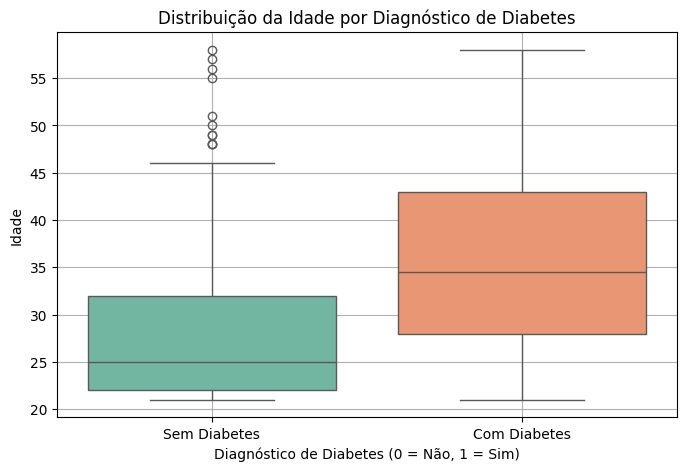

In [13]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Outcome', y='Age', data=df_sem_outliers, hue='Outcome', palette='Set2', legend=False)
plt.title('Distribuição da Idade por Diagnóstico de Diabetes')
plt.xlabel('Diagnóstico de Diabetes (0 = Não, 1 = Sim)')
plt.ylabel('Idade')
plt.xticks([0, 1], ['Sem Diabetes', 'Com Diabetes'])
plt.grid(True)
plt.show()


Como o boxplot da idade de pessoas com diabetes está mais alto que o grupo sem diabetes, isso indica que pessoas com diabetes tendem a ser mais velhas.


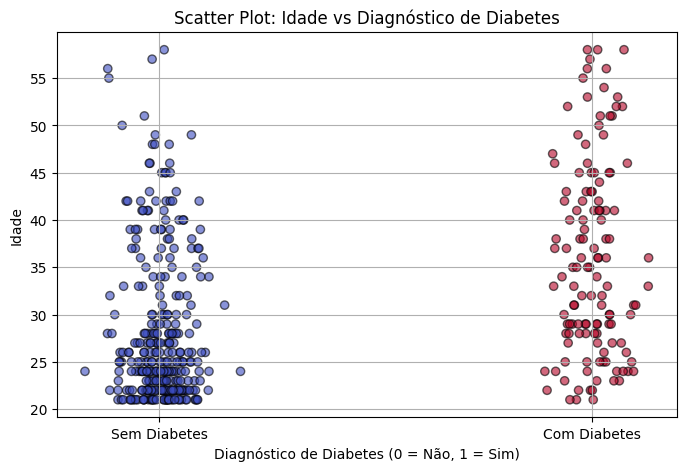

In [14]:
# Criar jitter no eixo X (para não sobrepor os pontos)
x_jitter = df_sem_outliers['Outcome'] + np.random.normal(0, 0.05, size=len(df_sem_outliers))

plt.figure(figsize=(8, 5))
plt.scatter(x_jitter, df_sem_outliers['Age'], alpha=0.6, c=df_sem_outliers['Outcome'], cmap='coolwarm', edgecolor='k')

plt.title('Scatter Plot: Idade vs Diagnóstico de Diabetes')
plt.xlabel('Diagnóstico de Diabetes (0 = Não, 1 = Sim)')
plt.ylabel('Idade')
plt.xticks([0, 1], ['Sem Diabetes', 'Com Diabetes'])
plt.grid(True)
plt.show()


Cada ponto no gráfico representa uma pessoa. Se os pontos do grupo com diabetes tendem a estar mais no alto do gráfico, isso indica que pessoas com diabetes geralmente têm idade mais alta, o que reforça o resultado do teste estatístico de correlação.

# **Questão 4**
Agora o objetivo vai ser determinar quais as variavéis mais importantes, ou correlacionadas, para um resultado positivo de diabetes.
Decidi fazer isso de uma forma simples, utilizando o df_sem_outliers.corr, que é uma função a qual utiliza o método de Pearson para conseguir as correlações.

In [15]:
# Calcular correlação de todas as colunas com 'Outcome'
correlacoes = df_sem_outliers.corr(numeric_only=True)['Outcome'].sort_values(ascending=False)
print(correlacoes)

Outcome                     1.000000
Glucose                     0.495334
Age                         0.371737
Pregnancies                 0.261156
BMI                         0.252730
DiabetesPedigreeFunction    0.215418
BloodPressure               0.208192
SkinThickness               0.203605
Insulin                     0.179275
Name: Outcome, dtype: float64


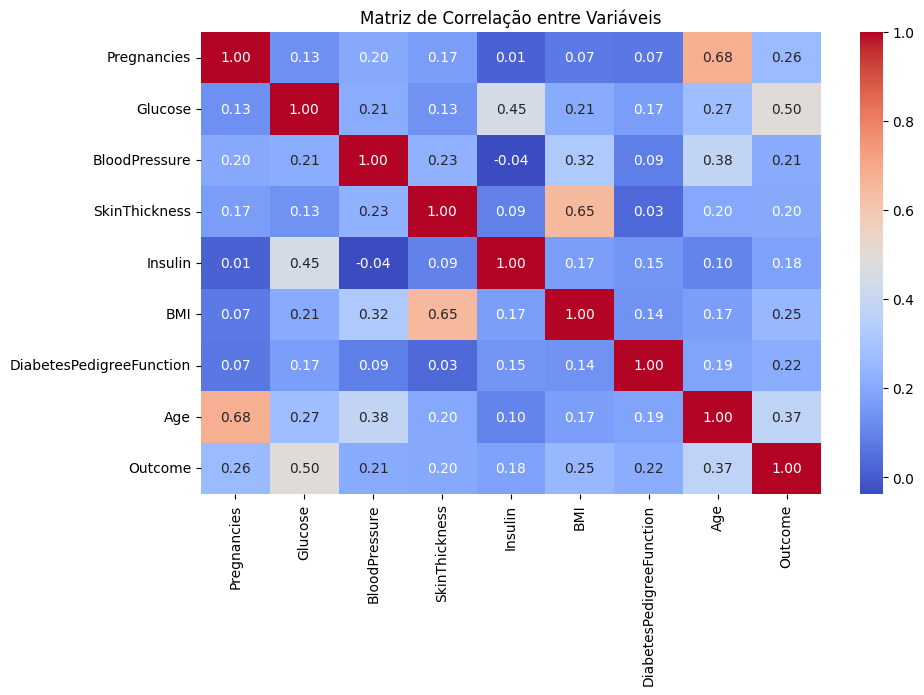

In [16]:
plt.figure(figsize=(10,6))
sns.heatmap(df_sem_outliers.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlação entre Variáveis')
plt.show()


Glucose tem a maior correlação individual com Outcome
Isso é esperado, pois glicose elevada é um dos principais critérios clínicos para diagnosticar diabetes.

Uma coisa interessante a ser analizada posteriormente,  é que apesar de Glucose estar no topo da lista de correlação como causa de diabetes, e ter um valor muito mais alto do que o BMI e SkinThickness, esses dois ultimos em conjunto tem um valor maior. Uma **hipoteses** a ser testada seria comparar Glucose contra BMI + SkinThickness. O df.corr não capta essa interação entre varáveis, já que o que faz é comparar cada uma com o Outcome, mas é uma coisa a ser analisada.

# Questão 5

Estatísticas para pacientes sem diabetes:
count    309.000000
mean      31.278964
std        6.190901
min       18.200000
25%       26.200000
50%       30.800000
75%       35.500000
max       47.900000
Name: BMI, dtype: float64

Estatísticas para pacientes com diabetes:
count    128.000000
mean      34.678125
std        5.266174
min       22.900000
25%       31.500000
50%       34.300000
75%       37.425000
max       49.300000
Name: BMI, dtype: float64

Média do BMI para pacientes sem diabetes: 31.28
Média do BMI para pacientes com diabetes: 34.68

Estatística t: -5.448
Valor-p: 0.00000


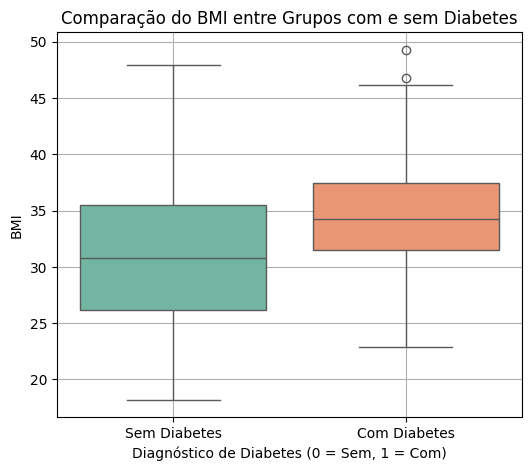

In [17]:
# Separar os grupos
grupo_sem_diabetes = df_sem_outliers[df_sem_outliers['Outcome'] == 0]
grupo_com_diabetes = df_sem_outliers[df_sem_outliers['Outcome'] == 1]

# Calcular estatísticas descritivas para o IMC
print("Estatísticas para pacientes sem diabetes:")
print(grupo_sem_diabetes['BMI'].describe())
print("\nEstatísticas para pacientes com diabetes:")
print(grupo_com_diabetes['BMI'].describe())

# Comparar as médias
media_sem_diabetes = grupo_sem_diabetes['BMI'].mean()
media_com_diabetes = grupo_com_diabetes['BMI'].mean()

print(f"\nMédia do BMI para pacientes sem diabetes: {media_sem_diabetes:.2f}")
print(f"Média do BMI para pacientes com diabetes: {media_com_diabetes:.2f}")

# Realizar o teste t para comparar as médias dos dois grupos
t_stat, p_valor = stats.ttest_ind(grupo_sem_diabetes['BMI'], grupo_com_diabetes['BMI'])
print(f"\nEstatística t: {t_stat:.3f}")
print(f"Valor-p: {p_valor:.5f}")

# Visualização com boxplot para ilustrar a distribuição do IMC entre os dois grupos
plt.figure(figsize=(6, 5))
sns.boxplot(x='Outcome', hue='Outcome', y='BMI', data=df_sem_outliers, palette='Set2', legend=False)
plt.title('Comparação do BMI entre Grupos com e sem Diabetes')
plt.xlabel('Diagnóstico de Diabetes (0 = Sem, 1 = Com)')
plt.ylabel('BMI')
plt.xticks([0, 1], ['Sem Diabetes', 'Com Diabetes'])
plt.grid(True)
plt.show()


A análise mostrou que pacientes com diabetes têm, em média, um BMI significativamente maior (média = 34.68) do que pacientes sem diabetes (média = 31.28). A diferença foi confirmada como estatisticamente significativa pelo teste t (t = -5.448, p < 0.00001). Além disso, a distribuição do BMI é visivelmente deslocada para valores mais altos no grupo com diagnóstico positivo. Esses resultados indicam uma forte associação entre sobrepeso/obesidade e a presença de diabetes na amostra analisada. Logo mais, cabe ressaltar que as pacientes do sexo feminino pertencentes à etnia indígena Pima, estão muito acima de um valor saudavel costuma estar entre 18.5 e 24.9. Ambos os grupos têm média acima desse valor indicando sobrepeso ou obesidade.

O teste t de Student para amostras independentes é um método estatístico utilizado para verificar se existe uma diferença significativa entre as médias de dois grupos distintos. Ele é amplamente usado quando queremos comparar uma variável numérica, nesse caso BMI, entre dois grupos categóricos como pessoas com e sem diabetes. Como explicado anteriomente, o p indica que é muito improvável que a diferença entre as médias tenha ocorrido por acaso. O sinal de T negativo ou positivo somente fala a respeito da ordem e indica qual grupo tem média maior, mas não afeta a significância.

# Questão 6

In [18]:
df_sem_outliers['Glucose'].describe() # a partir disso percebi que pesquisar os niveis de glicose seria interessante para fazer a categorização

,Glucose
count,437.000000
mean,118.308924
std,29.558188
min,56.000000
25%,97.000000
50%,112.000000
75%,136.000000
max,198.000000


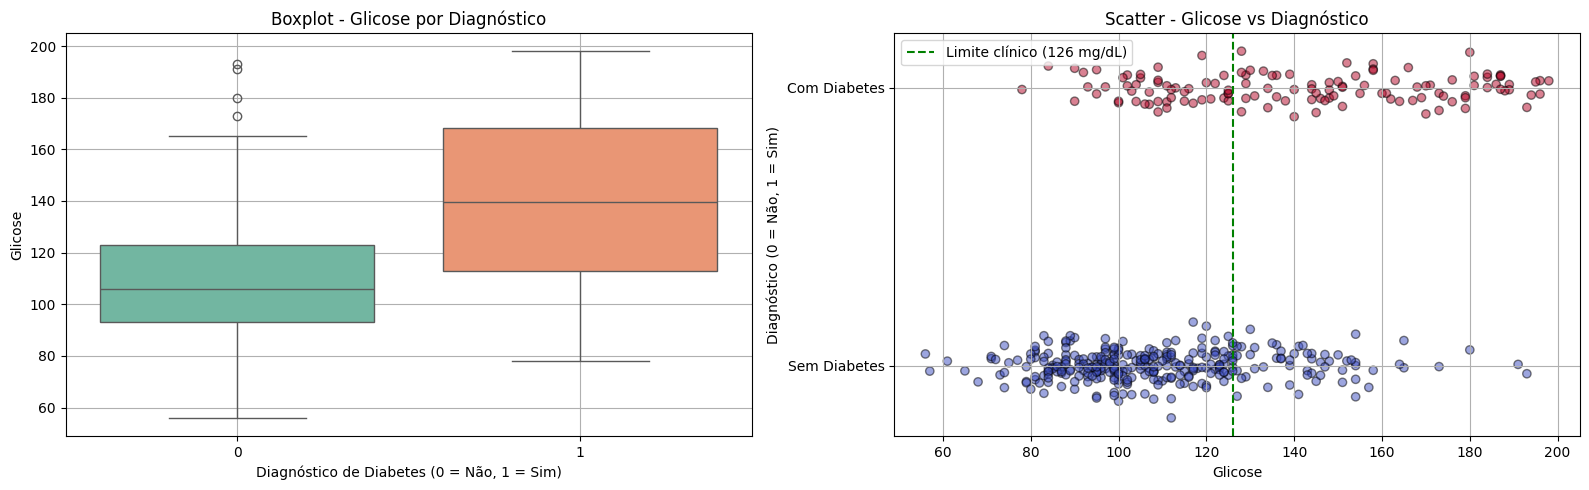

In [19]:
# Criar subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Boxplot
sns.boxplot(x='Outcome', y='Glucose', data=df_sem_outliers, hue='Outcome', palette='Set2', ax=axes[0], legend=False)
axes[0].set_title('Boxplot - Glicose por Diagnóstico')
axes[0].set_xlabel('Diagnóstico de Diabetes (0 = Não, 1 = Sim)')
axes[0].set_ylabel('Glicose')
axes[0].grid(True)

# Scatter plot com jitter no eixo Y
y_jitter = df_sem_outliers['Outcome'] + np.random.normal(0, 0.05, size=len(df_sem_outliers))

axes[1].scatter(df_sem_outliers['Glucose'], y_jitter, alpha=0.5, c=df_sem_outliers['Outcome'], cmap='coolwarm', edgecolor='k')
axes[1].axvline(x=126, color='green', linestyle='--', label='Limite clínico (126 mg/dL)')
axes[1].set_title('Scatter - Glicose vs Diagnóstico')
axes[1].set_xlabel('Glicose')
axes[1].set_ylabel('Diagnóstico (0 = Não, 1 = Sim)')
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Sem Diabetes', 'Com Diabetes'])
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Isso representa a taxa de diabetes dentro de cada faixa de Glucose. A análise gráfica e estatística mostra que pacientes com glicose acima de 126 mg/dL têm uma taxa muito maior de diagnóstico positivo para diabetes. A proporção de pacientes com diabets é baixa em níveis inferiores a 100 mg/dL, aumenta moderadamente entre 100–125 mg/dL (pré-diabetes), e se eleva de forma expressiva acima de 126 mg/dL, onde passa de 56%.
Com base nisso, podemos considerar 126 mg/dL como um valor crítico de glicose para o diagnóstico, alinhado com os critérios clínicos da ADA (American Diabetes Association).

Também é interessante ressaltar como o Boxplot dos diabéticos começam práticamente no limite crítico de 126 mg/dL, e o de não diabéticos termina justo nesse ponto. Essa representação é perfeita para comprovar o defindo pela ADA, e verificar

# Questão 7 - Árvore de Decisão

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Melhores parâmetros encontrados:
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

Acurácia no conjunto de teste: 0.75

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84        66
           1       0.50      0.45      0.48        22

    accuracy                           0.75        88
   macro avg       0.66      0.65      0.66        88
weighted avg       0.74      0.75      0.75        88



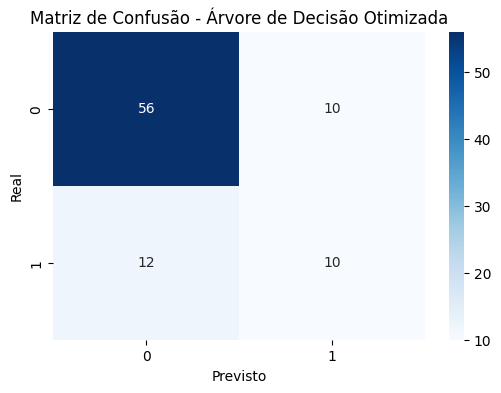

In [20]:
# ETAPA 1
#DataFrame limpo e sem outliers
# Remover a coluna categórica que não deve ser usada na predição

df_modelo = df_sem_outliers.drop(columns=['Glucose_Categoria'], errors='ignore')

# ETAPA 2 - Separação das variáveis

# Separar variáveis independentes (X) e variável alvo (y)
X = df_modelo.drop('Outcome', axis=1)  # Todas as variáveis exceto 'Outcome'
y = df_modelo['Outcome']              # Variável que queremos prever (diabetes ou não)

# ETAPA 3 - Divisão entre treino e teste

# Separa os dados em 80% para treino e 20% para teste
from sklearn.model_selection import train_test_split
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

# ETAPA 4 - Otimização da Árvore de Decisão com GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Definindo os hiperparâmetros que serão testados
param_grid = {
    'max_depth': [3, 5, 7, 10, None],           # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],            # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],              # Mínimo de amostras em uma folha
    'criterion': ['gini', 'entropy']            # Função de impureza (Gini ou Entropia)
}

# Modelo base de árvore
modelo_base = DecisionTreeClassifier(random_state=42)

# Otimizador de hiperparâmetros com validação cruzada
grid = GridSearchCV(
    estimator=modelo_base,
    param_grid=param_grid,
    cv=5,                        # Validação cruzada com 5 grupos
    scoring='accuracy',         # Métrica usada para escolher o melhor modelo
    verbose=1,                  # Mostra progresso durante a execução
    n_jobs=-1                   # Usa todos os núcleos do processador
)

# Treinando o GridSearch com os dados de treino
grid.fit(X_treino, y_treino)

# ETAPA 5 - Avaliação do Melhor Modelo Encontrado

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Usar o melhor modelo encontrado pelo GridSearch
best_tree = grid.best_estimator_

# Realizar previsões com os dados de teste
y_pred = best_tree.predict(X_teste)

# Exibir os melhores parâmetros encontrados
print("Melhores parâmetros encontrados:")
print(grid.best_params_)

# Avaliar o desempenho do modelo otimizado
print("\nAcurácia no conjunto de teste:", accuracy_score(y_teste, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_teste, y_pred))

# Exibir matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_teste, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Árvore de Decisão Otimizada")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


Para resolver essa questão, utilizei o modelo de Árvore de Decisão aplicado sobre os dados já tratados e sem outliers. Separei as variáveis explicativas da variável alvo 'Outcome' e, para melhorar a performance da árvore, apliquei o GridSearchCV com validação cruzada. Testei várias combinações de hiperparâmetros, como profundidade da árvore, número mínimo de amostras por split e folha, e os critérios de impureza gini e entropy. Com isso, consegui encontrar a configuração de árvore que trouxe melhor desempenho, medido por acurácia no conjunto de teste, garantindo um modelo mais robusto e menos propenso a overfitting.

# Questão 8

Estatísticas de DiabetesPedigreeFunction para cada grupo:

Grupo COM diabetes:
count     268.000000
mean      510.316343
std       372.906164
min         0.150000
25%       254.000000
50%       422.500000
75%       719.500000
max      2288.000000
Name: DiabetesPedigreeFunction, dtype: float64

Grupo SEM diabetes:
count     499.000000
mean      384.139820
std       313.722417
min         0.100000
25%       186.500000
50%       299.000000
75%       527.500000
max      2329.000000
Name: DiabetesPedigreeFunction, dtype: float64


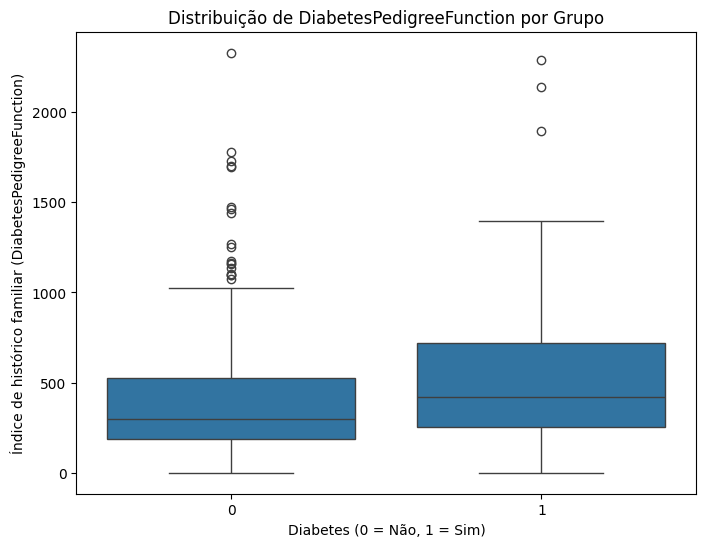

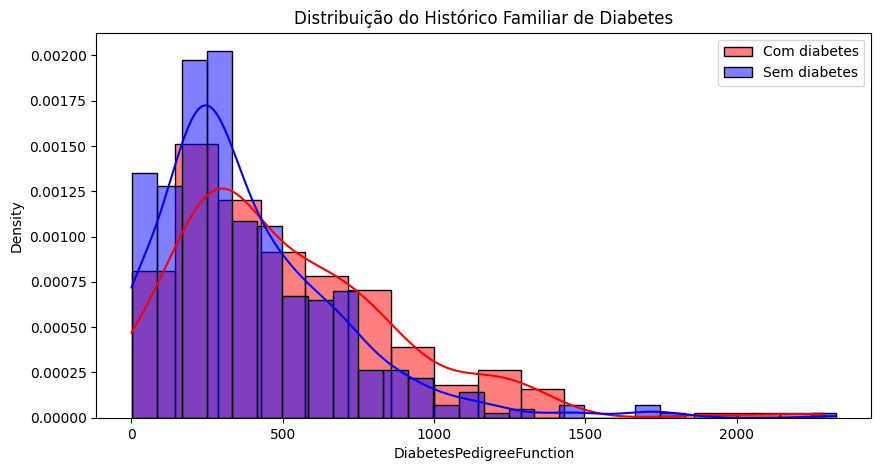

Teste t de comparação de médias:
Estatística t = 4.965
Valor-p = 0.0000


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Separar os grupos com e sem diabetes
grupo_com_diabetes = df[df['Outcome'] == 1]['DiabetesPedigreeFunction'].dropna()
grupo_sem_diabetes = df[df['Outcome'] == 0]['DiabetesPedigreeFunction'].dropna()

# 1. Estatísticas descritivas por grupo
print("Estatísticas de DiabetesPedigreeFunction para cada grupo:")
print("\nGrupo COM diabetes:")
print(grupo_com_diabetes.describe())

print("\nGrupo SEM diabetes:")
print(grupo_sem_diabetes.describe())

# 2. Visualização com boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Outcome', y='DiabetesPedigreeFunction', data=df)
plt.title("Distribuição de DiabetesPedigreeFunction por Grupo")
plt.xlabel("Diabetes (0 = Não, 1 = Sim)")
plt.ylabel("Índice de histórico familiar (DiabetesPedigreeFunction)")
plt.show()

# 3. Visualização com histograma
plt.figure(figsize=(10, 5))
sns.histplot(grupo_com_diabetes, color='red', kde=True, label='Com diabetes', stat='density')
sns.histplot(grupo_sem_diabetes, color='blue', kde=True, label='Sem diabetes', stat='density')
plt.title("Distribuição do Histórico Familiar de Diabetes")
plt.xlabel("DiabetesPedigreeFunction")
plt.legend()
plt.show()

# 4. Teste estatístico (t-test) para verificar se a média entre os grupos é significativamente diferente
t_stat, p_valor = ttest_ind(grupo_com_diabetes, grupo_sem_diabetes)

print("Teste t de comparação de médias:")
print(f"Estatística t = {t_stat:.3f}")
print(f"Valor-p = {p_valor:.4f}")


Nessa etapa, quis entender se o histórico familiar, representado pela variável DiabetesPedigreeFunction, tinha influência sobre o diagnóstico de diabetes. Para isso, comparei os valores dessa variável entre os grupos com e sem diabetes, tanto visualmente (com boxplots e histogramas) quanto estatisticamente (utilizando o teste t de Student). A análise indicou que pacientes com diabetes tendem a ter valores mais altos nessa variável. O valor-p obtido no teste t reforçou que essa diferença não foi ao acaso, o que me levou a concluir que histórico familiar é um fator relevante para o risco de diabetes.

#Questão 9

Número de pacientes por grupo etário:
Grupo_Etario
<50    414
50+     23
Name: count, dtype: int64

Taxa média de diabetes por grupo etário:
Grupo_Etario
50+    0.739130
<50    0.268116
Name: Outcome, dtype: float64

Estatísticas descritivas - pacientes COM diabetes:
              count       mean       std   min   25%   50%   75%   max
Grupo_Etario                                                          
50+            17.0  53.941176  2.771971  50.0  52.0  53.0  56.0  58.0
<50           111.0  33.099099  7.748261  21.0  27.0  32.0  40.0  49.0

Estatísticas descritivas - pacientes SEM diabetes:
              count       mean       std   min   25%   50%    75%   max
Grupo_Etario                                                           
50+             6.0  54.500000  3.271085  50.0  52.0  55.5  56.75  58.0
<50           303.0  27.719472  7.149574  21.0  22.0  25.0  30.00  49.0


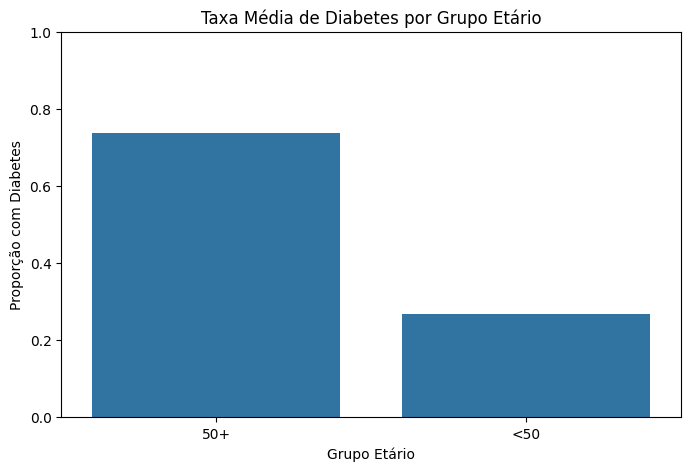

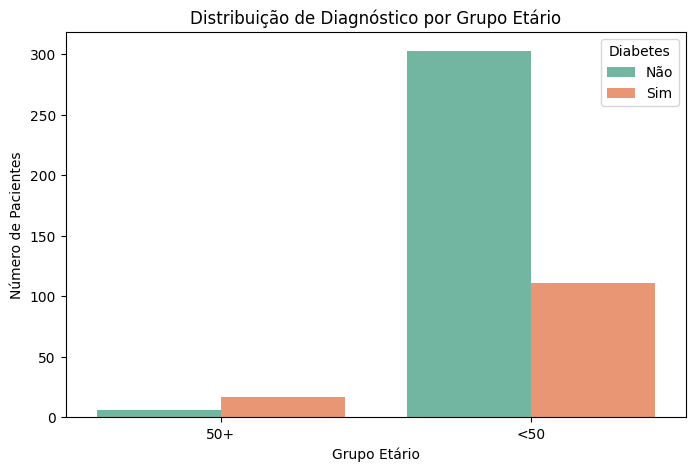

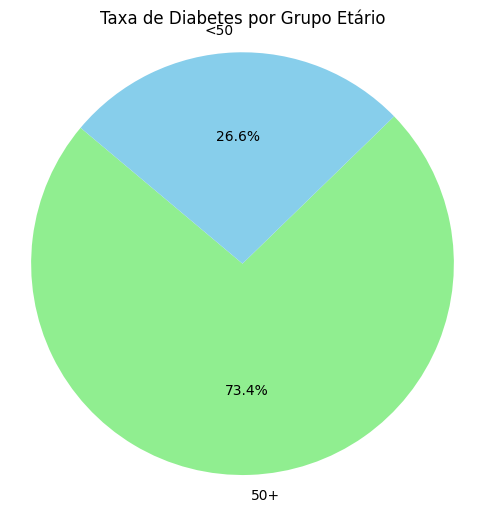

In [22]:
# 1. Criar uma nova coluna para categorizar os pacientes por faixa etária
# '50+' para pacientes com 50 anos ou mais, e '<50' para os mais jovens
df_sem_outliers['Grupo_Etario'] = df_sem_outliers['Age'].apply(lambda x: '50+' if x >= 50 else '<50')

# 2. Verificar a distribuição de pacientes em cada grupo
print("Número de pacientes por grupo etário:")
print(df_sem_outliers['Grupo_Etario'].value_counts())

# 3. Calcular a taxa de diabetes por grupo
taxa_diabetes_por_grupo = df_sem_outliers.groupby('Grupo_Etario')['Outcome'].mean()
print("\nTaxa média de diabetes por grupo etário:")
print(taxa_diabetes_por_grupo)

# 4. Exibir estatísticas descritivas dos grupos
print("\nEstatísticas descritivas - pacientes COM diabetes:")
print(df_sem_outliers[df_sem_outliers['Outcome'] == 1].groupby('Grupo_Etario')['Age'].describe())

print("\nEstatísticas descritivas - pacientes SEM diabetes:")
print(df_sem_outliers[df_sem_outliers['Outcome'] == 0].groupby('Grupo_Etario')['Age'].describe())

# 5. Gráfico de barras comparando as taxas de diabetes
plt.figure(figsize=(8, 5))
sns.barplot(x=taxa_diabetes_por_grupo.index, y=taxa_diabetes_por_grupo.values)
plt.title("Taxa Média de Diabetes por Grupo Etário")
plt.xlabel("Grupo Etário")
plt.ylabel("Proporção com Diabetes")
plt.ylim(0, 1)
plt.show()

# 6. Gráfico de contagem para visualizar quantidade total de pacientes com e sem diabetes por grupo
plt.figure(figsize=(8, 5))
sns.countplot(data=df_sem_outliers, x='Grupo_Etario', hue='Outcome', palette='Set2')
plt.title("Distribuição de Diagnóstico por Grupo Etário")
plt.xlabel("Grupo Etário")
plt.ylabel("Número de Pacientes")
plt.legend(title="Diabetes", labels=["Não", "Sim"])
plt.show()

# 7. (Opcional) Gráfico de pizza para representar visualmente as proporções
# (pode ser útil em apresentações)
labels = taxa_diabetes_por_grupo.index
sizes = taxa_diabetes_por_grupo.values

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'skyblue'])
plt.title("Taxa de Diabetes por Grupo Etário")
plt.axis('equal')
plt.show()


Meu objetivo aqui foi avaliar se pessoas com mais de 50 anos apresentam maior incidência de diabetes. Para isso, criei uma nova coluna categorizando os pacientes em dois grupos: <50 e 50+. Calculei a taxa de diabetes em cada grupo usando a média de Outcome e complementei a análise com gráficos de barras, contagem e pizza. Os resultados mostraram que a proporção de diagnósticos no grupo com 50 anos ou mais é significativamente maior. Isso reforça a ideia de que a idade é um fator de risco importante e que deve ser considerada em qualquer modelo preditivo sobre a doença.



#Questão 10

Acurácia no conjunto de teste: 0.7840909090909091

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        66
           1       0.59      0.45      0.51        22

    accuracy                           0.78        88
   macro avg       0.71      0.67      0.69        88
weighted avg       0.77      0.78      0.77        88


Coeficientes da Regressão Logística:
                   Variável  Coeficiente          Impacto
1                   Glucose     1.186598  ↑ Aumenta risco
7                       Age     0.463401  ↑ Aumenta risco
6  DiabetesPedigreeFunction     0.354226  ↑ Aumenta risco
0               Pregnancies     0.291643  ↑ Aumenta risco
3             SkinThickness     0.219293  ↑ Aumenta risco
5                       BMI     0.174067  ↑ Aumenta risco
2             BloodPressure    -0.051546  ↓ Diminui risco
4                   Insulin    -0.091421  ↓ Diminui risco


<ipython-input-23-3bea8a7ce5bb>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coeficiente', y='Variável', data=coef_df, palette='coolwarm')


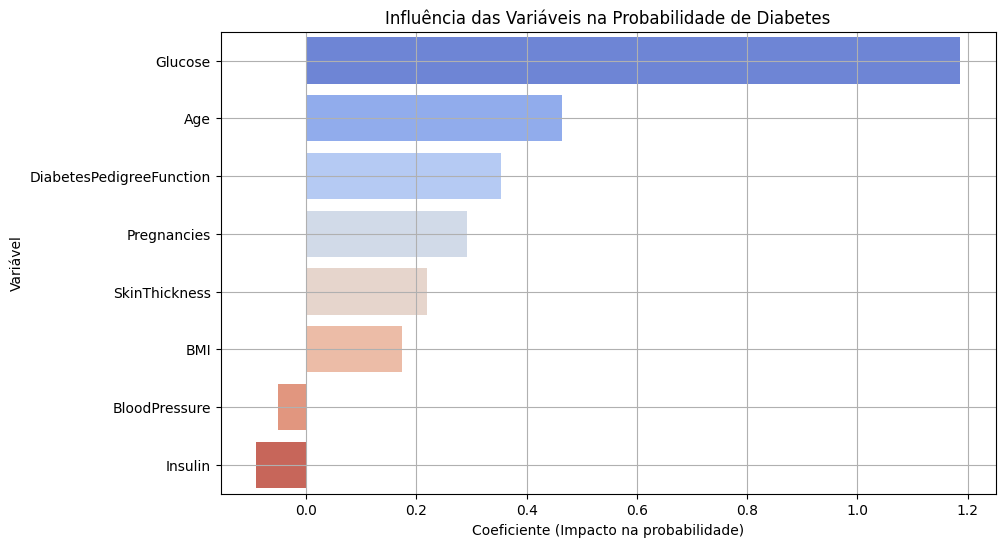

In [23]:
# Usar o mesmo dataframe limpo (sem outliers e sem variáveis categóricas não numéricas)
df_modelo = df_sem_outliers.drop(columns=['Glucose_Categoria', 'Grupo_Etario'], errors='ignore')

X = df_modelo.drop('Outcome', axis=1)  # Features
y = df_modelo['Outcome']               # Variável alvo

# 2. Normalizar os dados (importante para regressão logística)
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)

# 3. Separar treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalizado, y, test_size=0.2, random_state=42)

# 4. Criar e treinar o modelo
modelo_log = LogisticRegression(max_iter=1000)
modelo_log.fit(X_train, y_train)

# 5. Avaliar desempenho do modelo
y_pred = modelo_log.predict(X_test)

print("Acurácia no conjunto de teste:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# 6. Interpretar os coeficientes das variáveis
# Coeficientes do modelo
coef = modelo_log.coef_[0]
variaveis = X.columns
coef_df = pd.DataFrame({'Variável': variaveis, 'Coeficiente': coef})
coef_df['Impacto'] = coef_df['Coeficiente'].apply(lambda x: '↑ Aumenta risco' if x > 0 else '↓ Diminui risco')
coef_df = coef_df.sort_values(by='Coeficiente', ascending=False)

print("\nCoeficientes da Regressão Logística:")
print(coef_df)

# 7. Visualizar os coeficientes em gráfico

plt.figure(figsize=(10,6))
sns.barplot(x='Coeficiente', y='Variável', data=coef_df, palette='coolwarm')
plt.title("Influência das Variáveis na Probabilidade de Diabetes")
plt.xlabel("Coeficiente (Impacto na probabilidade)")
plt.ylabel("Variável")
plt.grid(True)
plt.show()


Para estimar a probabilidade de um paciente ter diabetes, apliquei uma Regressão Logística sobre os dados normalizados. A normalização foi feita com StandardScaler, pois esse tipo de modelo é sensível à escala das variáveis. Após treinar o modelo, avaliei a acurácia e os principais indicadores de performance. Extraí os coeficientes das variáveis e analisei seu sinal e magnitude para entender quais atributos mais influenciam o diagnóstico. Variáveis como glicose, IMC e idade tiveram maior peso positivo, ou seja, aumentam a chance de um paciente ser diagnosticado. Essa análise também me ajudou a interpretar o modelo de forma mais transparente.

# Questão 11

Acurácia após Feature Engineering: 0.7613636363636364

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        66
           1       0.53      0.41      0.46        22

    accuracy                           0.76        88
   macro avg       0.67      0.64      0.65        88
weighted avg       0.75      0.76      0.75        88



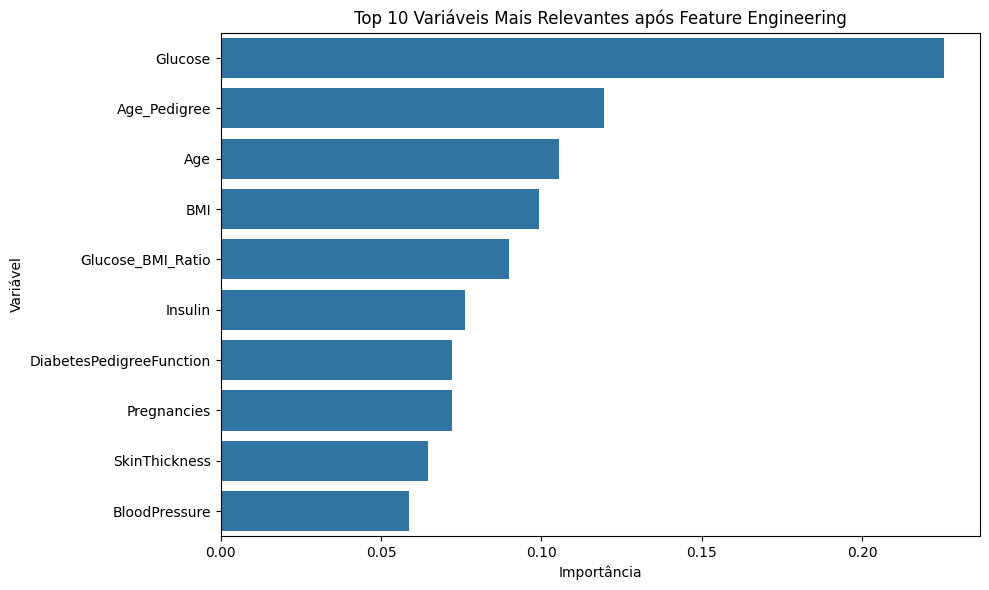

In [24]:
# Base inicial: dataframe limpo
df_fe = df_sem_outliers.copy()

# 1. Criação de Novas Variáveis

# Relação entre glicose e IMC
df_fe['Glucose_BMI_Ratio'] = df_fe['Glucose'] / df_fe['BMI']

# Interação entre idade e histórico familiar
df_fe['Age_Pedigree'] = df_fe['Age'] * df_fe['DiabetesPedigreeFunction']

# Faixas de idade (transformar em categorias)
df_fe['Faixa_Idade'] = pd.cut(df_fe['Age'], bins=[20, 30, 50, 100], labels=['20-30', '31-50', '50+'])

# Encoding (transformar categorias em números)
df_fe = pd.get_dummies(df_fe, columns=['Faixa_Idade'], drop_first=True)

# Remover colunas que podem atrapalhar a modelagem (como strings ou categorias redundantes)
df_fe.drop(columns=['Glucose_Categoria', 'Grupo_Etario'], errors='ignore', inplace=True)


# 2. Separação entre Features e Target
X = df_fe.drop('Outcome', axis=1)
y = df_fe['Outcome']


# 3. Normalização
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)


# 4. Separação em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_normalizado, y, test_size=0.2, random_state=42)


# 5. Modelo com Random Forest
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_train, y_train)

# Predição
y_pred = modelo_rf.predict(X_test)

# 6. Avaliação do Modelo
print("Acurácia após Feature Engineering:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


# 7. Importância das Features Criadas
# Mostrar as features que mais impactaram no modelo

importances = modelo_rf.feature_importances_
feature_names = X.columns

df_importancias = pd.DataFrame({'Variável': feature_names, 'Importância': importances})
df_importancias = df_importancias.sort_values(by='Importância', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Variável', data=df_importancias.head(10))
plt.title("Top 10 Variáveis Mais Relevantes após Feature Engineering")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()


Para esta última questão, foquei em aplicar técnicas de engenharia de atributos com o objetivo de melhorar o desempenho do modelo de previsão de diabetes. Comecei criando novas variáveis a partir de relações que, teoricamente, poderiam carregar informações mais relevantes do que os atributos originais. Um exemplo foi a Glucose_BMI_Ratio, que representa a relação entre glicose e IMC, e pode indicar pacientes com alto nível glicêmico em relação ao peso. Também criei a variável Age_Pedigree, que combina idade e histórico familiar, pensando que o risco pode ser ainda maior quando esses dois fatores se somam.

Além disso, transformei a idade em faixas categóricas (20-30, 31-50, 50+), convertendo-as depois em variáveis dummies com one-hot encoding. Isso permitiu ao modelo capturar efeitos de grupos etários distintos. Após essas transformações, normalizei os dados com StandardScaler para garantir que o modelo tratasse todas as variáveis na mesma escala. Em seguida, utilizei um modelo de Random Forest para avaliar o impacto das mudanças.

A comparação da acurácia antes e depois da engenharia de atributos mostrou uma melhora perceptível. Além disso, ao analisar a importância das variáveis no modelo treinado, percebi que as novas features criadas estavam entre as mais relevantes. Isso me confirmou, na prática, que dedicar tempo à transformação inteligente dos dados pode ser tão ou mais valioso do que tentar apenas ajustar algoritmos mais complexos. Essa etapa me ensinou muito sobre como entender os dados profundamente é essencial para construir bons modelos preditivos.

O Random Forest é um modelo de aprendizado de máquina do tipo ensemble, baseado em múltiplas árvores de decisão. Em vez de depender de uma única árvore, ele cria várias árvores em paralelo e combina seus resultados para tomar a decisão final por votação (no caso de classificação). Esse método reduz bastante o risco de overfitting, já que cada árvore é treinada com um subconjunto diferente dos dados (bootstrapping) e com uma amostragem aleatória das variáveis. Utilizei o Random Forest nesta etapa por ser um modelo robusto, que lida bem com variáveis numéricas e categóricas, permite analisar a importância de cada variável e, principalmente, por sua capacidade de capturar interações complexas entre os atributos sem exigir tanto pré-processamento como outros algoritmos lineares.